# MScFE 652: Portfolio Management - GWP 1 (Group 4272)

Members:
1. Patapongrat Lertbuaban
2. Shivani Verma
3. Chinmay Hegde

# Step 1: Defining Factors and Its Importances

The Fama-French 5-factor model consists of 5 factors, which are defined as follows (Kenneth R. French - Description of Fama/French Factors):

**SMB (Small Minus Big)**

This factor looks at the difference between the returns of smaller and larger stocks. Specifically, it calculates the average return of nine small stock portfolios minus the average return of nine large stock portfolios. The idea is to see if smaller companies tend to perform differently from larger ones.

**HML (High Minus Low)**

HML examines the difference between the returns of value stocks and growth stocks. It calculates the average return of two value portfolios minus the average return of two growth portfolios. The idea is to see if stocks with high book-to-market value ratios (value stocks) perform differently from those with low ratios (growth stocks).

**RMW (Robust Minus Weak)**

This factor compares the returns of portfolios with robust operating profitability to those with weak operating profitability. It calculates the average return of two robust portfolios minus the average return of two weak portfolios. The idea is to see if companies with strong profitability perform differently from those with weaker profitability.

**CMA (Conservative Minus Aggressive)**

This factor calculates the average return of two conservative portfolios minus the average return of two aggressive portfolios. The focus is on whether companies with conservative investment strategies perform differently from those with aggressive strategies.

**Rm-Rf**

This is the excess return on the overall market. It looks at the return of all publicly-traded companies listed on major stock exchanges in the U.S. after adjusting for the one-month Treasury bill rate. The purpose is to understand how the overall market performs relative to a risk-free investment like Treasury bills.


According to Fama and French (2014), their research indicates that the Fama-French five-factor model is capable of explaining a significant portion, ranging from 71% to 94%, of the cross-sectional variance in expected returns for portfolios categorized by size, value, profitability, and investment. In essence, the research demonstrates that a five-factor model tailored to capture variations in size, value, profitability, and investment delivers better performance than the simpler three-factor model, reducing the unexplained aspects of average returns. Fama and French (2014) further note that the highest expected returns are associated with companies that are small, profitable, and value-oriented, with limited growth prospects (“Fama French 5 Factor Model and Its Applications”).

Therefore, these findings are in line with many years of research in finance, showing that these factors help explain the returns. However, these models can become less accurate if new factors emerges.



# Step 2: Data Preparation

## Step 2a: Importing Daily Factor Returns

In this section, we will download the daily factor returns and analyze them in terms of their behaviors and correlations. The most recent three years time period is selected (i.e., from 2020/07/31 to 2023/07/31).

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [43]:
# Data preparation
ff3_factors = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows = 3)
ff5_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows = 3)
ff3_factors = ff3_factors.rename(columns={"Unnamed: 0": "Date"})[:-1].set_index('Date')
ff5_factors = ff5_factors.rename(columns={"Unnamed: 0": "Date"})[:-1].set_index('Date')
ff3_factors.index = pd.to_datetime(ff3_factors.index, format='%Y%m%d')
ff5_factors.index = pd.to_datetime(ff5_factors.index, format='%Y%m%d')
ff3_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100
ff5_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff5_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] / 100

The illustrations of the daily returns of all 3 factors (FF3) and all 5 factors (FF5) are shown below.

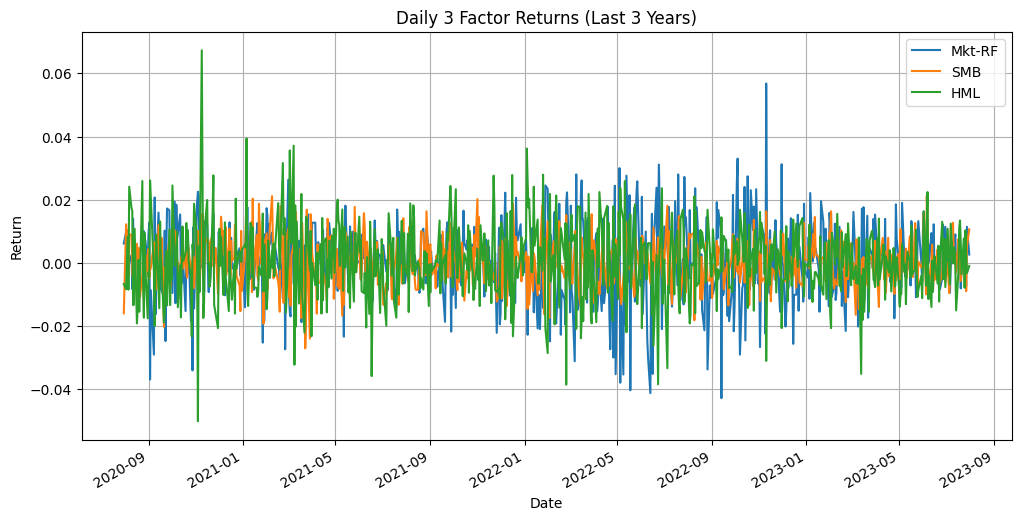

In [44]:
# Select the last 3 years of data
ff3_factors = ff3_factors.loc['2020-07-31':'2023-07-31']

# Plot the daily factor returns
ff3_factors[['Mkt-RF', 'SMB', 'HML']].plot(figsize=(12, 6))
plt.title('Daily 3 Factor Returns (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

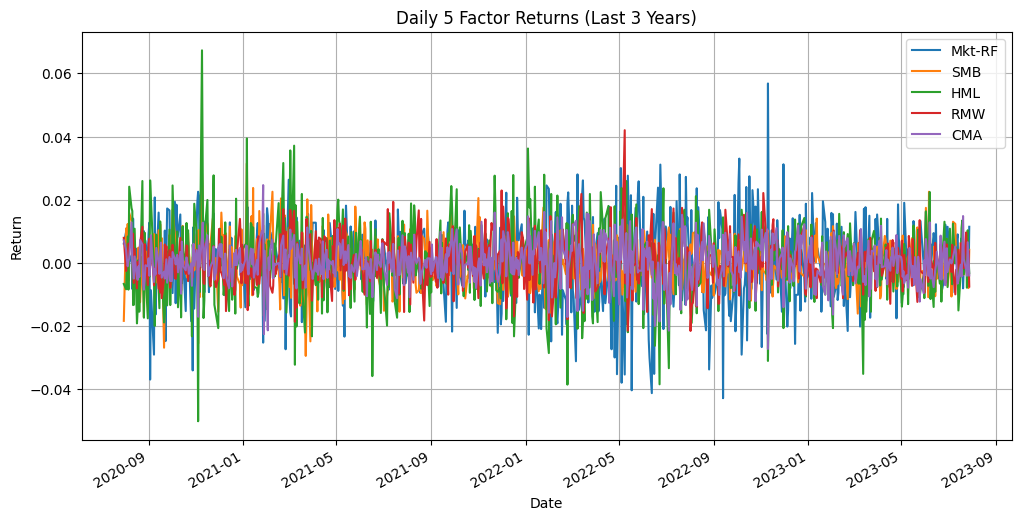

In [45]:
# Select the last 3 years of data
ff5_factors = ff5_factors.loc['2020-07-31':'2023-07-31']

# Plot the daily factor returns
ff5_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].plot(figsize=(12, 6))
plt.title('Daily 5 Factor Returns (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

From the results, we can observe a significant volatility in Mkt-RF and HML throughout the period, while other factors seem to be very stable.

## Step 2b: Daily Factor Returns Correlation

The correlations of daily factor returns for the FF3 and FF5 models are shown below.

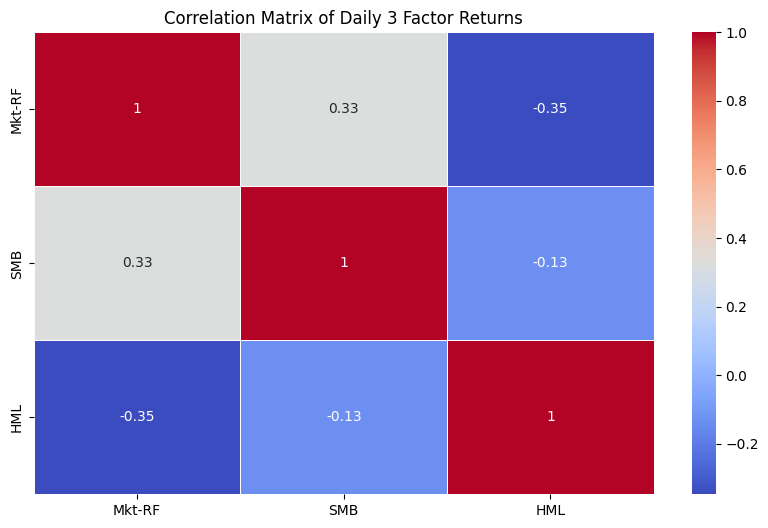

In [46]:
# Calculating correlation
ff3_corr = ff3_factors[['Mkt-RF', 'SMB', 'HML']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(ff3_corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Daily 3 Factor Returns')
plt.show()

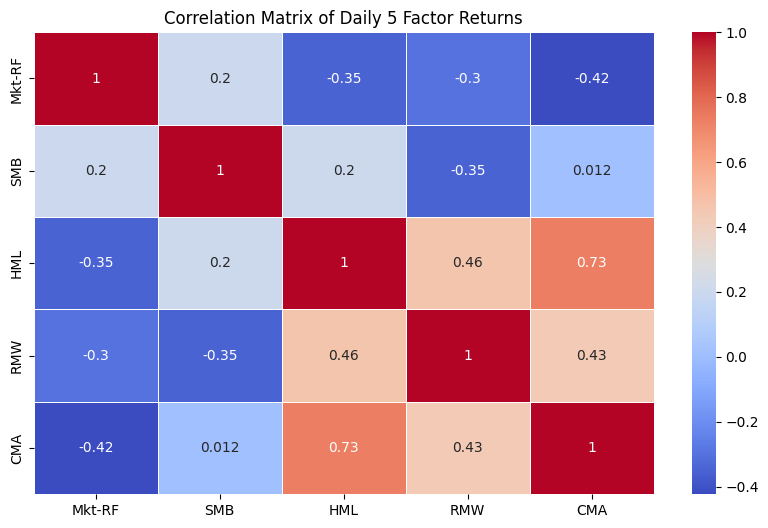

In [47]:
# Calculating correlation
ff5_corr = ff5_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(ff5_corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Daily 5 Factor Returns')
plt.show()

For the FF3 model, despite the fact that we can observe some correlations between all factors, the correlation between SMB and HML (-0.13) is very weak.
For the FF5 model, we observe strong correlations between HML and CMA (0.73), HML and RMW (0.46), and RMW and CMA (0.43). Apart from these factors, we can observe some correlations. The weakest correlation can be found between SMB and CMA (0.012).

## Step 2c: Collecting Economic Data

In this section, we collect the daily 13-week Treasury yield and the daily 10-year Treasury yield over the past 3 years (i.e., from 2020/07/31 to 2023/07/31). The illustrations are shown below.

[*********************100%***********************]  1 of 1 completed


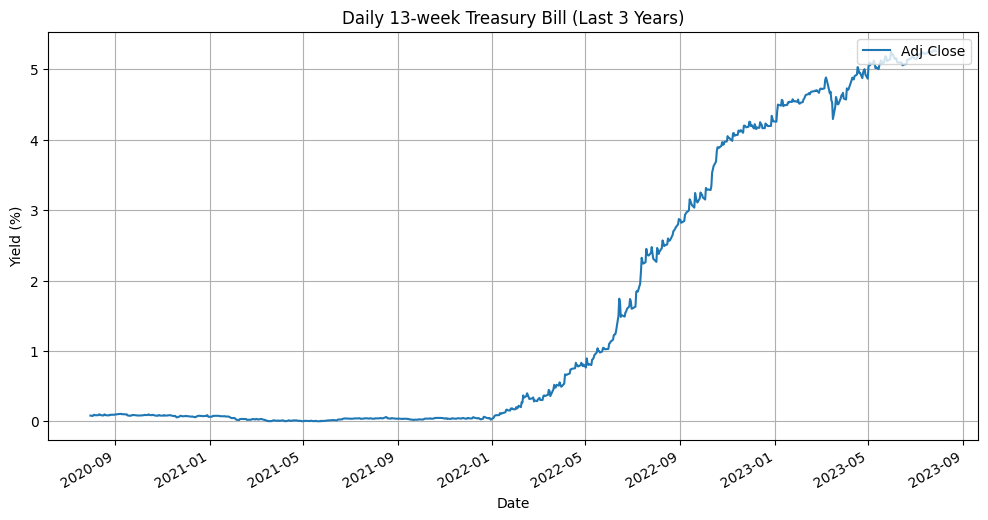

In [48]:
# Downloading the 13-week Treasury yield during the last 3 years
start_date = "2020-07-31"
end_date = "2023-07-31"

treasury_bill_symbol = "^IRX"
treasury_bill_data = yf.download(treasury_bill_symbol, start=start_date, end=end_date)
treasury_bill_data = treasury_bill_data['Adj Close']

# Plot the treasury tield data
treasury_bill_data.plot(figsize=(12, 6))
plt.title('Daily 13-week Treasury Bill (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


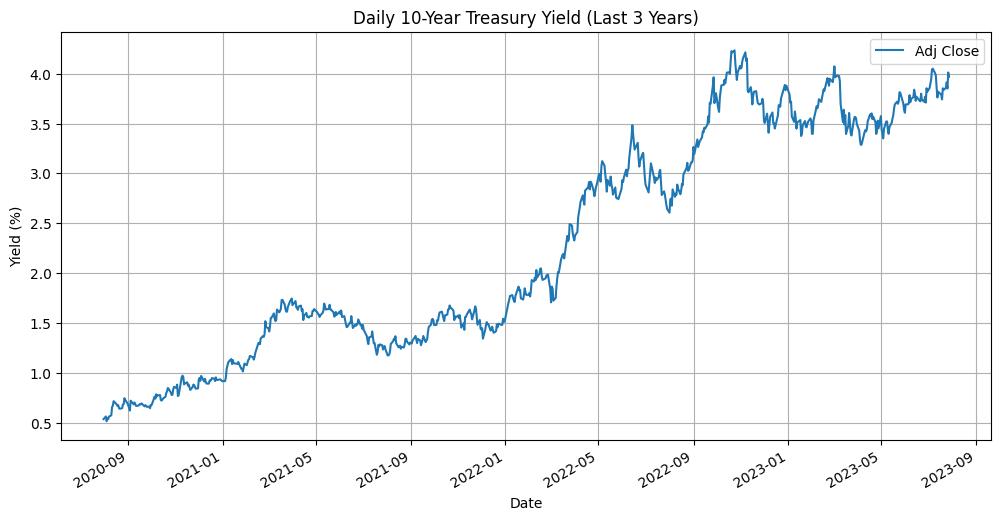

In [49]:
# Downloading the 10-year Treasury yield during the last 3 years
start_date = "2020-07-31"
end_date = "2023-07-31"

treasury_yield_symbol = "^TNX"
treasury_yield_data = yf.download(treasury_yield_symbol, start=start_date, end=end_date)
treasury_yield_data = treasury_yield_data['Adj Close']

# Plot the treasury tield data
treasury_yield_data.plot(figsize=(12, 6))
plt.title('Daily 10-Year Treasury Yield (Last 3 Years)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

From the figures above, we can observe a significant upward trend in the yield. This is due to the fact that the U.S. central bank has been raising interest rates in order to cope with a surge in inflation. In fact, the risk-free rate used in the Fama-French model (Rf) will increase, which can have implications for asset pricing.

# Step 3: FF3 Regressions

## Step 3a: Running the Regression Models

In this section, we will use simple linear regression and other robust regression models with the FF3 data. The coefficients of both models and their model metrics will also be discussed.

We will estimate the FF3 parameters for the Apple stock (AAPL) during the recent past three years (same as the above sections). We have used Time Series Split cross validation (i.e., cross validation on a rolling basis) to divided data into training and testing.

Then, we run the FF3 model by using four regression models including simple linear regression, Huber regression, and Theilsen regression. The Huber and Theilsen regressions are used in order to cope with the outliers in regression analysis. The full implementation is shown below.

In [50]:
aapl_prices = yf.download('AAPL', start=start_date, end=end_date)
aapl_prices = aapl_prices['Adj Close']
aapl_log_ret = np.log1p(aapl_prices.pct_change())[1:]

ff3_factors['AAPL'] = aapl_log_ret
ff5_factors['AAPL'] = aapl_log_ret
ff3_factors = ff3_factors.dropna()
ff5_factors = ff5_factors.dropna()

X = ff3_factors[['Mkt-RF', 'SMB', 'HML']]
y = ff3_factors['AAPL'] - ff3_factors['RF']

[*********************100%***********************]  1 of 1 completed


### Simple Linear Regression

In [51]:
def ls_model(X, y, no_factor=3):
    # Time series split cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_r2_ls = []
    all_mae_ls = []
    all_mse_ls = []
    all_beta_mkt_ls = []
    all_beta_smb_ls = []
    all_beta_hml_ls = []
    all_beta_rmw_ls = []
    all_beta_cma_ls = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_ls = LinearRegression()
        model_ls.fit(X_train, y_train)
        y_pred = model_ls.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        if no_factor == 5:
            beta_mkt, beta_smb, beta_hml, beta_rmw, beta_cma = model_ls.coef_

            all_r2_ls.append(r2)
            all_mae_ls.append(mae)
            all_mse_ls.append(mse)
            all_beta_mkt_ls.append(beta_mkt)
            all_beta_smb_ls.append(beta_smb)
            all_beta_hml_ls.append(beta_hml)
            all_beta_rmw_ls.append(beta_rmw)
            all_beta_cma_ls.append(beta_cma)

        else:
            beta_mkt, beta_smb, beta_hml = model_ls.coef_

            all_r2_ls.append(r2)
            all_mae_ls.append(mae)
            all_mse_ls.append(mse)
            all_beta_mkt_ls.append(beta_mkt)
            all_beta_smb_ls.append(beta_smb)
            all_beta_hml_ls.append(beta_hml)

    if no_factor == 5:
        return all_r2_ls, all_mae_ls, all_mse_ls, all_beta_mkt_ls, all_beta_smb_ls, all_beta_hml_ls, all_beta_rmw_ls, all_beta_cma_ls
    else:
        return all_r2_ls, all_mae_ls, all_mse_ls, all_beta_mkt_ls, all_beta_smb_ls, all_beta_hml_ls

### Huber Regression

In [52]:
def huber_model(X, y, no_factor=3):
    # Time series split cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_r2_huber = []
    all_mae_huber = []
    all_mse_huber = []
    all_beta_mkt_huber = []
    all_beta_smb_huber = []
    all_beta_hml_huber = []
    all_beta_rmw_huber = []
    all_beta_cma_huber = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_huber = HuberRegressor()
        model_huber.fit(X_train, y_train)
        y_pred = model_huber.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        if no_factor == 5:
            beta_mkt, beta_smb, beta_hml, beta_rmw, beta_cma = model_huber.coef_

            all_r2_huber.append(r2)
            all_mae_huber.append(mae)
            all_mse_huber.append(mse)
            all_beta_mkt_huber.append(beta_mkt)
            all_beta_smb_huber.append(beta_smb)
            all_beta_hml_huber.append(beta_hml)
            all_beta_rmw_huber.append(beta_rmw)
            all_beta_cma_huber.append(beta_cma)

        else:
            beta_mkt, beta_smb, beta_hml = model_huber.coef_

            all_r2_huber.append(r2)
            all_mae_huber.append(mae)
            all_mse_huber.append(mse)
            all_beta_mkt_huber.append(beta_mkt)
            all_beta_smb_huber.append(beta_smb)
            all_beta_hml_huber.append(beta_hml)

    if no_factor == 5:
        return all_r2_huber, all_mae_huber, all_mse_huber, all_beta_mkt_huber, all_beta_smb_huber, all_beta_hml_huber, all_beta_rmw_huber, all_beta_cma_huber
    else:
        return all_r2_huber, all_mae_huber, all_mse_huber, all_beta_mkt_huber, all_beta_smb_huber, all_beta_hml_huber

### TheilSen Regression

In [53]:
def theilsen_model(X, y, no_factor=3):
    # Time series split cross validation
    tscv = TimeSeriesSplit(n_splits=5)
    all_r2_ts = []
    all_mae_ts = []
    all_mse_ts = []
    all_beta_mkt_ts = []
    all_beta_smb_ts = []
    all_beta_hml_ts = []
    all_beta_rmw_ts = []
    all_beta_cma_ts = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_ts = TheilSenRegressor()
        model_ts.fit(X_train, y_train)
        y_pred = model_ts.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        if no_factor == 5:
            beta_mkt, beta_smb, beta_hml, beta_rmw, beta_cma = model_ts.coef_

            all_r2_ts.append(r2)
            all_mae_ts.append(mae)
            all_mse_ts.append(mse)
            all_beta_mkt_ts.append(beta_mkt)
            all_beta_smb_ts.append(beta_smb)
            all_beta_hml_ts.append(beta_hml)
            all_beta_rmw_ts.append(beta_rmw)
            all_beta_cma_ts.append(beta_cma)

        else:
            beta_mkt, beta_smb, beta_hml = model_ts.coef_

            all_r2_ts.append(r2)
            all_mae_ts.append(mae)
            all_mse_ts.append(mse)
            all_beta_mkt_ts.append(beta_mkt)
            all_beta_smb_ts.append(beta_smb)
            all_beta_hml_ts.append(beta_hml)

    if no_factor == 5:
        return all_r2_ts, all_mae_ts, all_mse_ts, all_beta_mkt_ts, all_beta_smb_ts, all_beta_hml_ts, all_beta_rmw_ts, all_beta_cma_ts
    else:
        return all_r2_ts, all_mae_ts, all_mse_ts, all_beta_mkt_ts, all_beta_smb_ts, all_beta_hml_ts

### Run the Model

In [54]:
all_r2_ls, all_mae_ls, all_mse_ls, all_beta_mkt_ls, all_beta_smb_ls, all_beta_hml_ls = ls_model(X, y)
all_r2_huber, all_mae_huber, all_mse_huber, all_beta_mkt_huber, all_beta_smb_huber, all_beta_hml_huber = huber_model(X, y)
all_r2_ts, all_mae_ts, all_mse_ts, all_beta_mkt_ts, all_beta_smb_ts, all_beta_hml_ts = theilsen_model(X, y)

## Step 3b: The FF3 Model Metrics and Parameters

### Summary of Model Results

In [55]:
# Simple LS Model results
print('Simple Linear Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_ls).round(3)}')
print(f'MAE: {np.mean(all_mae_ls).round(3)}')
print(f'MSE: {np.mean(all_mse_ls).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_ls).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_ls).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_ls).round(3)}\n')

# Huber Regression Model results
print('Huber Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_huber).round(3)}')
print(f'MAE: {np.mean(all_mae_huber).round(3)}')
print(f'MSE: {np.mean(all_mse_huber).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_huber).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_huber).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_huber).round(3)}\n')

# TheilSen Regression Model results
print('TheilSen Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_ts).round(3)}')
print(f'MAE: {np.mean(all_mae_ts).round(3)}')
print(f'MSE: {np.mean(all_mse_ts).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_ts).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_ts).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_ts).round(3)}\n')

Simple Linear Regression coefficients and model metrics:
R2: 0.674
MAE: 0.007
MSE: 9.5e-05
Beta (Mkt-Rf): 1.333
Beta (SMB): -0.339
Beta (HML): -0.408

Huber Regression coefficients and model metrics:
R2: 0.67
MAE: 0.007
MSE: 9.7e-05
Beta (Mkt-Rf): 1.369
Beta (SMB): -0.386
Beta (HML): -0.383

TheilSen Regression coefficients and model metrics:
R2: 0.677
MAE: 0.007
MSE: 9.4e-05
Beta (Mkt-Rf): 1.378
Beta (SMB): -0.453
Beta (HML): -0.375



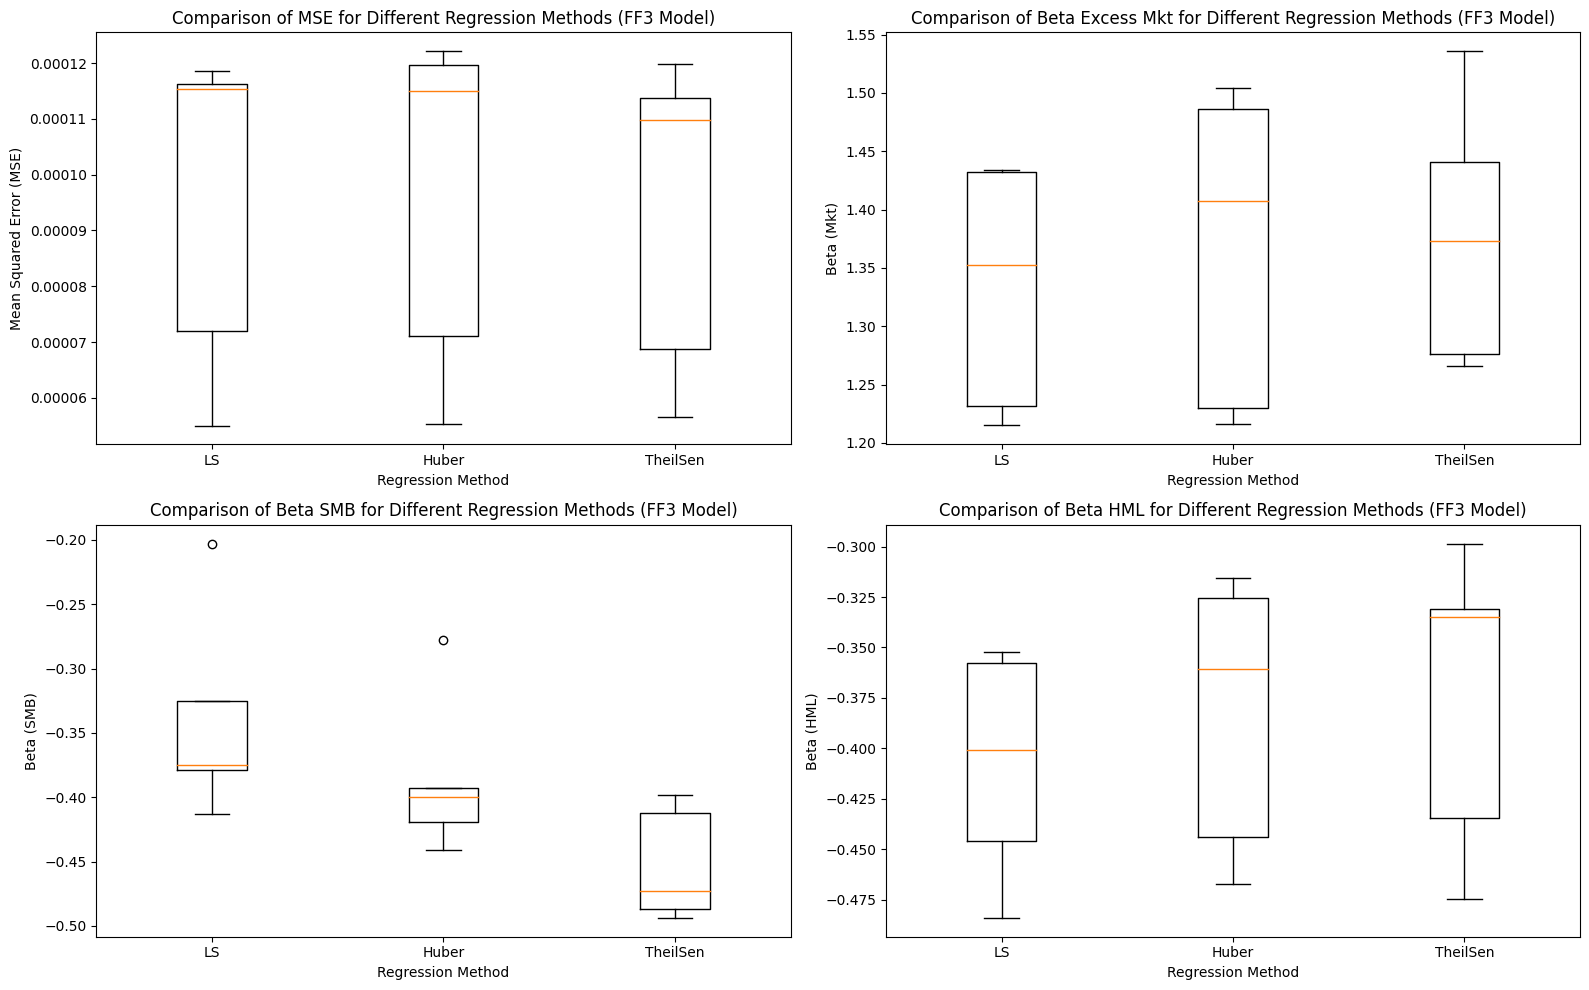

In [56]:
# Create the dictionaries
all_mse = {'LS': all_mse_ls, 'Huber': all_mse_huber, 'TheilSen': all_mse_ts}
all_beta_mkt = {'LS': all_beta_mkt_ls, 'Huber': all_beta_mkt_huber, 'TheilSen': all_beta_mkt_ts}
all_beta_smb = {'LS': all_beta_smb_ls, 'Huber': all_beta_smb_huber, 'TheilSen': all_beta_smb_ts}
all_beta_hml = {'LS': all_beta_hml_ls, 'Huber': all_beta_hml_huber, 'TheilSen': all_beta_hml_ts}

# Create another dictionary
data_dict = {'MSE': all_mse, 'Beta Excess Mkt': all_beta_mkt, 'Beta SMB': all_beta_smb, 'Beta HML': all_beta_hml}

# Create the y-labels
y_labels = {'MSE': 'Mean Squared Error (MSE)', 'Beta Excess Mkt': 'Beta (Mkt)', 'Beta SMB': 'Beta (SMB)', 'Beta HML': 'Beta (HML)'}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loop through the data
for i, (metric, data) in enumerate(data_dict.items()):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    # Create a list of lists
    data_list = [data['LS'], data['Huber'], data['TheilSen']]

    # Create a boxplot
    ax.boxplot(data_list, labels=['LS', 'Huber', 'TheilSen'])
    ax.set_xlabel('Regression Method')
    ax.set_ylabel(y_labels[metric])
    ax.set_title(f'Comparison of {metric} for Different Regression Methods (FF3 Model)')

# Show the results
plt.tight_layout()
plt.show()

From the results, we can observe that all three regression methods provide relatively consistent results. They all have similar R-squared values, indicating a good fit to the data, and similar prediction accuracy as indicated by MAE and MSE. The beta coefficients for the Fama-French factors are also consistent across the models. These results indicate that the choice of regression method may not significantly impact the model's performance in explaining the relationship between the Fama-French factors and the dependent variable.

In terms of the model parameters, the betas from each factor imply that AAPL is positively correlated with the overall market. The negative size factor implies that AAPL should be classified as a large-cap company, i.e., it is expected to perform better when the large-cap stocks outperform the small-cap stocks. The negative HML indicates that AAPL should be classified as a growth stock.

# Step 4: FF5 Regressions

## Step 4a: Running the Regression Models

The process is the same as in the FF3 model, but the FF5 formulation includes RMW and CMA factors. The full implementation is shown below.

In [57]:
X_ff5 = ff5_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
y_ff5 = ff5_factors['AAPL'] - ff5_factors['RF']

### Run the Model

In [58]:
all_r2_ls_ff5, all_mae_ls_ff5, all_mse_ls_ff5, all_beta_mkt_ls_ff5, all_beta_smb_ls_ff5, all_beta_hml_ls_ff5, all_beta_rmw_ls_ff5, all_beta_cma_ls_ff5 = ls_model(X_ff5, y_ff5, no_factor=5)
all_r2_huber_ff5, all_mae_huber_ff5, all_mse_huber_ff5, all_beta_mkt_huber_ff5, all_beta_smb_huber_ff5, all_beta_hml_huber_ff5, all_beta_rmw_huber_ff5, all_beta_cma_huber_ff5 = huber_model(X_ff5, y_ff5, no_factor=5)
all_r2_ts_ff5, all_mae_ts_ff5, all_mse_ts_ff5, all_beta_mkt_ts_ff5, all_beta_smb_ts_ff5, all_beta_hml_ts_ff5, all_beta_rmw_ts_ff5, all_beta_cma_ts_ff5 = theilsen_model(X_ff5, y_ff5, no_factor=5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Step 4b: The FF5 Model Metrics and Parameters

### Summary of Model Results

In [59]:
# Simple LS Model results
print('Simple Linear Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_ls_ff5).round(3)}')
print(f'MAE: {np.mean(all_mae_ls_ff5).round(3)}')
print(f'MSE: {np.mean(all_mse_ls_ff5).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_ls_ff5).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_ls_ff5).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_ls_ff5).round(3)}')
print(f'Beta (RMW): {np.mean(all_beta_rmw_ls_ff5).round(3)}')
print(f'Beta (CMA): {np.mean(all_beta_cma_ls_ff5).round(3)}\n')

# Huber Regression Model results
print('Huber Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_huber_ff5).round(3)}')
print(f'MAE: {np.mean(all_mae_huber_ff5).round(3)}')
print(f'MSE: {np.mean(all_mse_huber_ff5).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_huber_ff5).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_huber_ff5).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_huber_ff5).round(3)}')
print(f'Beta (RMW): {np.mean(all_beta_rmw_huber_ff5).round(3)}')
print(f'Beta (CMA): {np.mean(all_beta_cma_huber_ff5).round(3)}\n')

# TheilSen Regression Model results
print('TheilSen Regression coefficients and model metrics:')
print(f'R2: {np.mean(all_r2_ts_ff5).round(3)}')
print(f'MAE: {np.mean(all_mae_ts_ff5).round(3)}')
print(f'MSE: {np.mean(all_mse_ts_ff5).round(6)}')
print(f'Beta (Mkt-Rf): {np.mean(all_beta_mkt_ts_ff5).round(3)}')
print(f'Beta (SMB): {np.mean(all_beta_smb_ts_ff5).round(3)}')
print(f'Beta (HML): {np.mean(all_beta_hml_ts_ff5).round(3)}')
print(f'Beta (RMW): {np.mean(all_beta_rmw_ts_ff5).round(3)}')
print(f'Beta (CMA): {np.mean(all_beta_cma_ts_ff5).round(3)}\n')

Simple Linear Regression coefficients and model metrics:
R2: 0.699
MAE: 0.007
MSE: 9e-05
Beta (Mkt-Rf): 1.386
Beta (SMB): -0.371
Beta (HML): -0.891
Beta (RMW): 0.266
Beta (CMA): 1.765

Huber Regression coefficients and model metrics:
R2: 0.712
MAE: 0.007
MSE: 8.5e-05
Beta (Mkt-Rf): 1.381
Beta (SMB): -0.312
Beta (HML): -0.864
Beta (RMW): 0.351
Beta (CMA): 1.611

TheilSen Regression coefficients and model metrics:
R2: 0.72
MAE: 0.007
MSE: 8.3e-05
Beta (Mkt-Rf): 1.343
Beta (SMB): -0.327
Beta (HML): -0.894
Beta (RMW): 0.379
Beta (CMA): 1.549



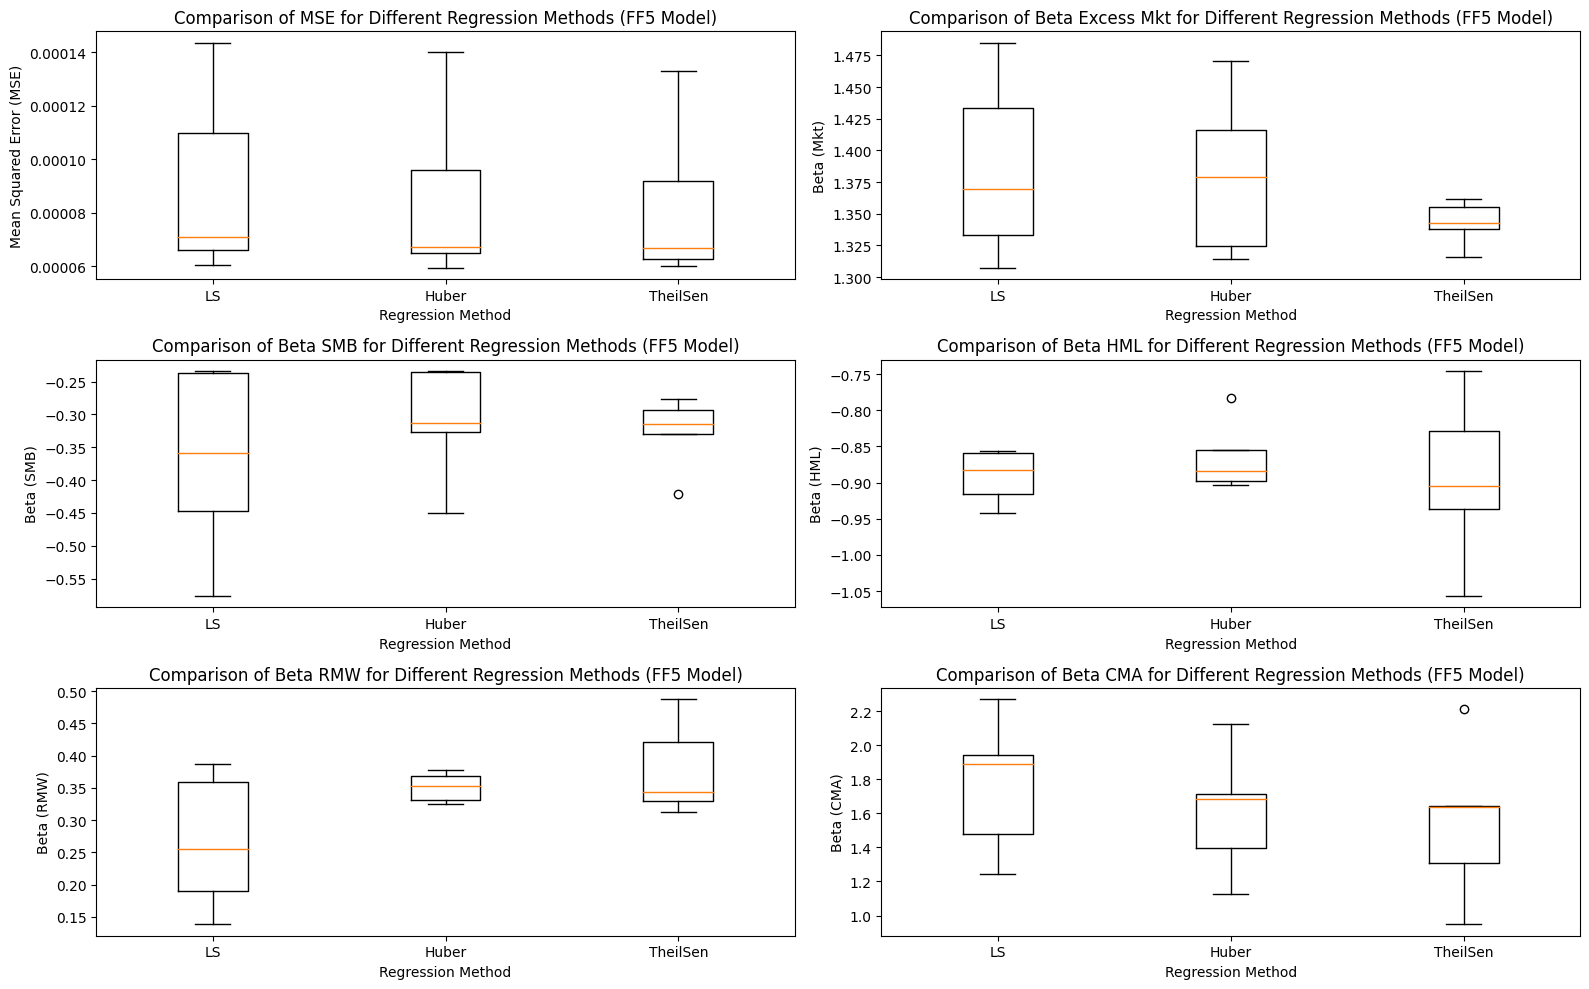

In [60]:
# Create the dictionaries for FF5 model
all_mse_ff5 = {'LS': all_mse_ls_ff5, 'Huber': all_mse_huber_ff5, 'TheilSen': all_mse_ts_ff5}
all_beta_mkt_ff5 = {'LS': all_beta_mkt_ls_ff5, 'Huber': all_beta_mkt_huber_ff5, 'TheilSen': all_beta_mkt_ts_ff5}
all_beta_smb_ff5 = {'LS': all_beta_smb_ls_ff5, 'Huber': all_beta_smb_huber_ff5, 'TheilSen': all_beta_smb_ts_ff5}
all_beta_hml_ff5 = {'LS': all_beta_hml_ls_ff5, 'Huber': all_beta_hml_huber_ff5, 'TheilSen': all_beta_hml_ts_ff5}
all_beta_rmw_ff5 = {'LS': all_beta_rmw_ls_ff5, 'Huber': all_beta_rmw_huber_ff5, 'TheilSen': all_beta_rmw_ts_ff5}
all_beta_cma_ff5 = {'LS': all_beta_cma_ls_ff5, 'Huber': all_beta_cma_huber_ff5, 'TheilSen': all_beta_cma_ts_ff5}

# Create another dictionary for FF5 model
data_dict_ff5 = {'MSE': all_mse_ff5, 'Beta Excess Mkt': all_beta_mkt_ff5, 'Beta SMB': all_beta_smb_ff5,
                 'Beta HML': all_beta_hml_ff5, 'Beta RMW': all_beta_rmw_ff5, 'Beta CMA': all_beta_cma_ff5}

# Create the y-labels for FF5 model
y_labels_ff5 = {'MSE': 'Mean Squared Error (MSE)', 'Beta Excess Mkt': 'Beta (Mkt)', 'Beta SMB': 'Beta (SMB)', 'Beta HML': 'Beta (HML)',
                'Beta RMW': 'Beta (RMW)', 'Beta CMA': 'Beta (CMA)'}

# Create subplots for FF5 model
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

# Loop through the data for FF5 model
for i, (metric, data) in enumerate(data_dict_ff5.items()):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    # Create a list of lists
    data_list = [data['LS'], data['Huber'], data['TheilSen']]

    # Create a boxplot for FF5 model
    ax.boxplot(data_list, labels=['LS', 'Huber', 'TheilSen'])
    ax.set_xlabel('Regression Method')
    ax.set_ylabel(y_labels_ff5[metric])
    ax.set_title(f'Comparison of {metric} for Different Regression Methods (FF5 Model)')

# Show the results for FF5 model
plt.tight_layout()
plt.show()

From the results, we can observe that the R2 score and the errors values are improved by using the robust regression methods. By observing the box plot, the range of values are tigher when the robust regression methods are used.

In terms of the model parameters, the betas from Mkt-Rf, SMB, and HML factors lead to the same conclusion as in the FF3 model. For RMW and CMA betas, we can conclude that AAPL tends to do well when companies with strong profits and careful investment approaches perform better than others.

# Step 5

The Correlation matrix of the Daily factor returns under FF3 and FF5 models are shown below:

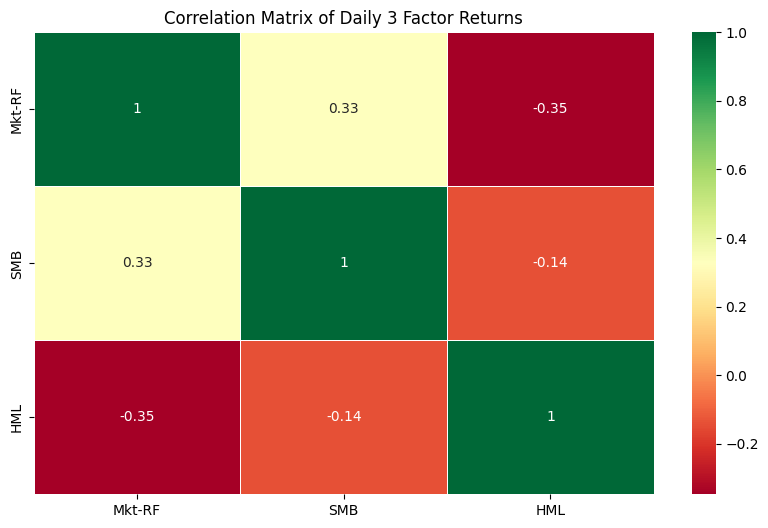

In [61]:
# Calculating correlation
ff3_corr = ff3_factors[['Mkt-RF', 'SMB', 'HML']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(ff3_corr, annot=True, cmap="RdYlGn", linewidths=0.5)
plt.title('Correlation Matrix of Daily 3 Factor Returns')
plt.show()

# Step 6

# Step 7

# Step 8

# References

Brownlee, Jason. “Robust Regression for Machine Learning in Python.” *MachineLearningMastery*, 11 June 2020, machinelearningmastery.com/robust-regression-for-machine-learning-in-python.

“Fama French 5 Factor Model and Its Applications.” *Quantitative Finance & Algo Trading Blog by QuantInsti*, 16 Mar. 2023, blog.quantinsti.com/fama-french-five-factor-asset-pricing-model.

Horstmeyer, Derek. “Fama and French: The Five-Factor Model Revisited.” *CFA Institute Enterprising Investor*, 14 Jan. 2022, blogs.cfainstitute.org/investor/2022/01/10/fama-and-french-the-five-factor-model-revisited.

“How to Download Fama French 3 Factor Model Data in Python.” *CodingFinance*, 10 June 2018, www.codingfinance.com/post/2018-06-10-download-ff-data-in-py.

*Kenneth R. French - Description of Fama/French Factors*. mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html.

Shrivastava, Soumya. “Cross Validation in Time Series” *Medium*, 14 Sept. 2023, medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4.

Teo, Bee Guan. “Estimating Stock Returns With Fama-French Three-Factor Model in Python.” *Medium*, 5 Jan. 2022, medium.com/the-handbook-of-coding-in-finance/estimating-stock-returns-with-fama-french-three-factor-model-in-python-1a98e3936859.

WorldQuant. *Factor Model in Portfolio Theory - Portfolio Management Module*.